<a href="https://colab.research.google.com/github/Sompote/RIC_paper/blob/main/LSTM_CNN_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This code is for a transformer for predict RIC results combindnation of LSTM and CON1D together to predict RIC
*   The feature was add to encoding data
*   initial qc value is in [:,:,0]




In [ ]:
!pip install -q keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.1/880.1 kB 9.6 MB/s eta 0:00:00


In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"

# Note that keras_core should only be imported after the backend
# has been configured. The backend cannot be changed once the
# package is imported.
import keras_core as keras

In [1]:
#Transformer Autoencoder to predict RIC combind model by Dr. Sompote Youwai 2023
import numpy as np
import pandas as pd

# Import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd



df = pd.read_excel('/content/drive/MyDrive/RIC/data_17aug.xlsx')
data=np.array(df)
X=data[:,1:29]
Y=data[:,34:62]
x_feature=data[:,29:32]




In [ ]:
X.shape

(26, 28)

In [2]:
def movingavarage(array,window):
  X = np.apply_along_axis(lambda x: np.convolve(x, np.ones(window)/window, mode='valid'), axis=1, arr=array)
  return X
#scale data
X_train=X
Y_train=Y
sc_y=StandardScaler()
sc = StandardScaler()
sc_f=StandardScaler()
X_feature=x_feature
X_train=X

x_train = sc.fit_transform(X_train)
y_train=sc_y.fit_transform(Y_train)
x_feature=sc_f.fit_transform(X_feature)

X_train_smooth=movingavarage(x_train,3)
Y_train_smooth=movingavarage(y_train,3)


In [3]:
X_train_CNN=np.zeros((X.shape[0],X.shape[1],X_feature.shape[1]+1))
X_train_CNN[:,:,0]=x_train
for i in range(0,(X.shape[0])):
  X_train_CNN[i,:,1]=x_feature[i,0]
  X_train_CNN[i,:,2]=x_feature[i,1]
  X_train_CNN[i,:,3]=x_feature[i,2]

In [ ]:
y_train.shape

(26, 28)

In [4]:
#split data
X_train, X_test, X_feature_train, X_feature_test, Y_train, Y_test = train_test_split(X_train_CNN, x_feature, y_train, random_state=1,test_size=0.2)

#_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
#X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
#X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))


In [ ]:
X_train=X_train_CNN
Y_train=y_train
X_feature_train=x_feature

In [ ]:
Y_train.shape

(26, 28)

In [5]:
#Model generation part
#import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, Flatten, concatenate,Reshape, Dropout,Bidirectional,LayerNormalization
from keras.layers import MaxPooling1D
from keras.layers import LSTM, Dense
from keras.metrics import MeanAbsolutePercentageError
from keras import *
from keras.optimizers import Adam
#from attention import Attention




def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0.2, attention_axes=None):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def CNN_model(cnn_input_shape):
  # Create the CNN model
  cnn_input = Input(shape=cnn_input_shape,name='CNN_input')
  cnn_output = Conv1D(filters=128, kernel_size=4, activation='sigmoid')(cnn_input)
  cnn_output = Conv1D(filters=64, kernel_size=2, activation='sigmoid')(cnn_output)
  #cnn_output = Attention(units=32)(cnn_output)
  #layer=transformer_encoder(cnn_input, head_size=24, num_heads=10, ff_dim=2,
    #                    dropout=0.2, attention_axes=None)
  cnn_output = Flatten()(cnn_output)
  x = Dropout(0.2)(cnn_output)

  cnn_output = Dense(50, activation='linear')(x)
  #cnn_output=  LayerNormalization(epsilon=1e-6)(cnn_output)

  cnn_model = Model(inputs=cnn_input, outputs=cnn_output,name='CNN_model')
  return cnn_model

def LSTM_model_attention(dense_input_shape):
  # Create the dense model
  # Use the function parameter as the input shape
  dense_input = Input(shape=dense_input_shape,name='LSTM_input')
  layer=transformer_encoder(dense_input, head_size=24, num_heads=10, ff_dim=2,
                        dropout=0.2,squences=True)(layer)

  head_size=64
  num_heads=10
  ff_dim=2
  num_trans_blocks=12
  dropout=0.1
  attention_axes=1
  x = layers.LayerNormalization(epsilon=1e-6)(dense_output)
  x = layers.LayerNormalization(epsilon=1e-6)( x)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(0.1)(x)
  res = x+dense_output
  #dense_output = Attention(units=32)(dense_output)
  layer = Flatten()(res)

  dense_output = Dense(200, activation='sigmoid')(layer)
  dense_output = Dense(50, activation='linear')(layer)

def LSTM_model(dense_input_shape):
  # Create the dense model
  # Use the function parameter as the input shape
  dense_input = Input(shape=dense_input_shape,name='LSTM_input')
  layer=transformer_encoder(dense_input, head_size=24, num_heads=10, ff_dim=2,
                        dropout=0.2, attention_axes=None)

  dense_output = LSTM(200,return_sequences=True)(layer)

  layer = Flatten()(dense_output)
  x = Dropout(0.2)(layer)


  dense_output = Dense(200, activation='sigmoid')(x)
  dense_output = Dense(50, activation='linear')(layer)
  #dense_output=  LayerNormalization(epsilon=1e-6)(dense_output)

  dense_model = Model(inputs=dense_input, outputs=dense_output,name='LSTM_model')
  return dense_model

def encoding_model(LSTM_model,cnn_model,latent_dim):
  combined_input_cnn = cnn_model.output
  combined_input_LSTM = LSTM_model.output
  combined_input = concatenate([combined_input_LSTM,combined_input_cnn])
  layer=Dense(200, activation='sigmoid')(combined_input)
  combined_output = Dense(latent_dim, activation='linear')(layer)
  combined_model = Model(inputs=[LSTM_model.input,cnn_model.input], outputs=combined_output,name='encoding_model')
  return combined_model

def decoding_model1(latent_dim,feature_dim,time_step):
  inputs_l = Input(shape=latent_dim, name='latent')
  inputs_f = Input(shape=feature_dim, name='feature')
  layerf_int=  dense_output = Dense(40, activation='sigmoid')(inputs_f)
  layerfeature=  dense_output = Dense(latent_dim, activation='sigmoid')(layerf_int)
  combined_input = concatenate([inputs_l, layerfeature],name='combind_feature')
  layer=Dense(200, activation='sigmoid')(combined_input)
  layer=Dense(100, activation='tanh')(layer)
  layer=Dense(time_step, activation='tanh')(layer)
  layer=Reshape((time_step,1))(layer)
  LSTM_out =  LSTM(1,return_sequences=True)(layer)
  output=LSTM_out[:,:,0]


  #dense_output = Dense(time_step, activation='linear')(layer)

  model = Model([inputs_l,inputs_f], outputs=output,name='decoding_model')
  return model

def decoding_model(latent_dim,feature_dim,time_step):
  inputs_l = Input(shape=latent_dim, name='latent')
  inputs_f = Input(shape=feature_dim, name='feature')
  layerf_int=  Dense(40, activation='sigmoid')(inputs_f)
  layerfeature=  Dense(latent_dim, activation='sigmoid')(layerf_int)
  combined_input = concatenate([inputs_l, layerfeature],name='combind_feature')
  layer=Dense(200, activation='sigmoid')(combined_input)
  layer=Dropout(0.2)(layer)

  layer=Dense(100, activation='sigmoid')(layer)

  dense_output = Dense(time_step, activation='linear')(layer)
  output=dense_output
  model = Model([inputs_l,inputs_f], outputs=output,name='decoding_model')
  return model

def transformer(encoding_model,decoding_model,feature_dim):
  input_f = Input(shape=feature_dim, name='feature')
  #inputs_feature=Dense(feature_dim, activation='sigmoid')
  #inputs_f = decoding_model.input[1]
  input_l=encoding_model.output
  print(input_l)
  outputs = decoding_model([input_l,input_f])
  print(outputs)
  model = Model(inputs=[input_f,encoding_model.input], outputs=outputs,name='Transformer')
  return model



# Compile and summarize the combined model
#Main program

dense_input_shape = (X_train.shape[1])
cnn_input_shape = (X_train.shape[1],X_train.shape[2])
LSTM_input_shape=(X_train.shape[1],X_train.shape[2])


feature_dim=X_feature.shape[1]
latent_dim=16
time_step=Y_train.shape[1]
model_cnn=CNN_model(cnn_input_shape)
model_lstm= LSTM_model(LSTM_input_shape)

#model_combind=combind_model2(model_lstm,model_cnn,y_train)
model_encoding=encoding_model(model_lstm,model_cnn,latent_dim)
model_decoding=decoding_model(latent_dim,feature_dim,time_step)
model_transform=transformer(model_encoding,model_decoding,feature_dim)
#adam.learning_rate=0.001
model_transform.compile(optimizer='adam', loss='mse', metrics=['mae','mape'])
model_transform.summary()


#from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('model_best_weights.h5', monitor='loss', save_best_only=True)



history=model_transform.fit([X_feature_train,X_train, X_train],
                            Y_train, epochs=2000, batch_size=10,validation_data=([X_feature_test,X_test,X_test], Y_test))

KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='dense_4/BiasAdd:0', description="created by layer 'dense_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 28), dtype=tf.float32, name=None), name='decoding_model/dense_9/BiasAdd:0', description="created by layer 'decoding_model'")
Model: "Transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 LSTM_input (InputLayer)        [(None, 28, 4)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 28, 4)       8           ['LSTM_input[0][0]']             
 alization)                                                                                       
                                                                 

In [ ]:
def mape(y_true, y_pred):
  mape=np.mean(np.abs((Y - y_pred)/Y))*100
  # return mean of percentage errors
  return mape


def mae(y_true, y_pred):
  mae=np.mean(np.abs(Y - y_pred))
  # return mean of percentage errors
  return mae

y=model_transform.predict([x_feature,X_train_CNN,X_train_CNN])
y_pred=sc_y.inverse_transform(y)

mape=mape(Y,y_pred)
mae=mae(Y,y_pred)

print('MAPE=', mape)
print('MAE=', mae)


1/1 [==============================] - 1s 748ms/step
MAPE= 14.495617497742064
MAE= 0.6698409959182763


In [ ]:
y_pred

array([[ 9.936405  ,  9.92511   , 10.746154  , 13.376274  , 15.808869  ,
        14.390387  , 12.364955  , 13.783769  , 11.953229  ,  3.6295393 ,
         1.0102669 ,  0.6033862 ,  1.6225594 ,  3.040677  ,  2.2303567 ,
         2.0262249 ,  2.4186602 ,  2.2279153 ,  3.8518677 ,  3.4460318 ,
         2.4315188 ,  2.2237058 ,  4.0482078 ,  4.050908  ,  5.471232  ,
         6.889308  ,  9.119478  , 12.361978  ],
       [ 9.282993  , 12.511484  , 15.322268  , 13.162964  ,  8.63234   ,
         7.3410153 ,  9.709441  , 14.680973  ,  4.750803  ,  1.0716236 ,
         1.7749907 ,  1.935283  ,  2.587749  ,  2.3719602 ,  2.1584973 ,
         1.5083467 ,  2.3602085 ,  2.5845158 ,  2.8068    ,  2.5885503 ,
         2.8066046 ,  2.1509843 ,  3.2303011 ,  4.5297995 ,  5.8244643 ,
         4.9632955 ,  6.689611  ,  7.983313  ],
       [ 2.858696  ,  7.955239  ,  6.934647  ,  2.860315  ,  8.978506  ,
        12.44977   , 14.896129  , 19.189146  , 21.218275  , 22.23472   ,
         3.6743388 ,  1.0153

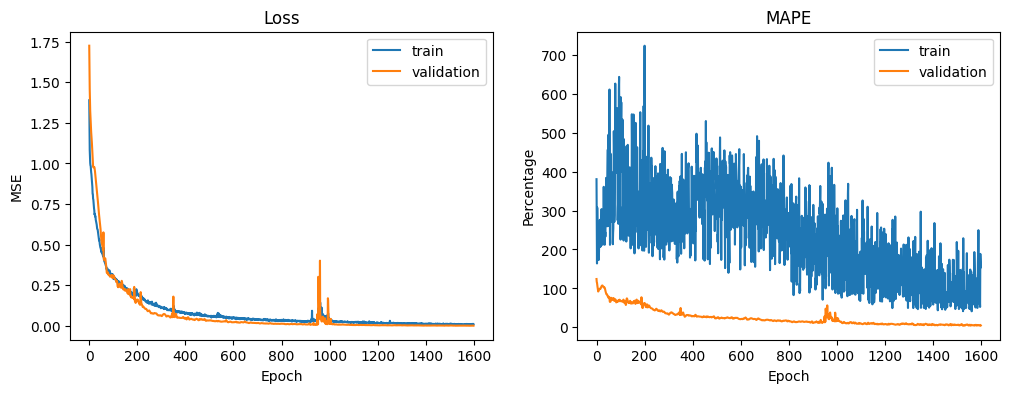

In [ ]:

# plot the loss and mape for train and validation sets
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mape'], label='train')
plt.plot(history.history['val_mape'], label='validation')
plt.title('MAPE')
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.legend()

plt.show()

Model: "Transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 LSTM_input (InputLayer)        [(None, 28, 4)]      0           []                               
                                                                                                  
 layer_normalization_162 (Layer  (None, 28, 4)       8           ['LSTM_input[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 CNN_input (InputLayer)         [(None, 28, 4)]      0           []                               
                                                                                                  
 multi_head_attention_81 (Multi  (None, 28, 4)       4564        ['layer_normalization_1

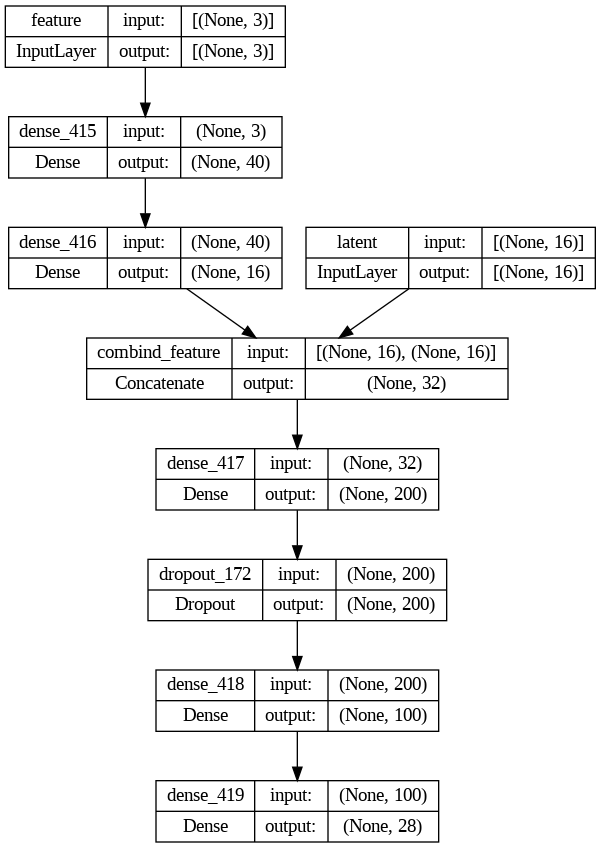

In [ ]:
# plot and save your model
import tensorflow as tf
model_transform.summary()
img_file = 'model_transform.png'
tf.keras.utils.plot_model(model_transform, to_file=img_file, show_shapes=True, show_layer_names=True)
img_file = 'model_decode.png'
tf.keras.utils.plot_model(model_decoding, to_file=img_file, show_shapes=True, show_layer_names=True)

In [ ]:
#validation
x_predictn=np.zeros((1,28))
#x_predictn[0,:]=[10,18,18,20,25,18,20,18,5,2,10,9,10,5,8,6,6,4,7,12,23,24,25,25,54,27,23]
x_predictn[0,:]=data[15,1:29]
X_predict = sc.transform(x_predictn)
x_feature=np.zeros((1,3))
x_feature[0,0]=100 #blow
x_feature[0,1]=2 #fine
x_feature[0,2]=3 #thickness
X_feature = sc_f.transform(x_feature)

x_cal=np.zeros((1,time_step,4))
x_cal[:,:,0]=X_predict
x_cal[:,:,1]=X_feature[0,0]
x_cal[:,:,2]=X_feature[0,1]
x_cal[:,:,3]=X_feature[0,2]
y=model_transform.predict([X_feature,x_cal,x_cal])
y=sc_y.inverse_transform(y)
print(y)
#plot


1/1 [==============================] - 0s 27ms/step
[[10.245591  12.592401  13.35635   13.181106  12.007132  11.720404
  11.3748045 14.492717   9.356986   4.7822633  1.4788691  2.353697
   2.328467   3.1192164  1.1120952  0.9794475  1.4308611  1.5673666
   3.225786   2.242891   2.0501564  2.2121     3.1537907  3.9142168
   5.578829   6.010139   7.697943  10.454303 ]]


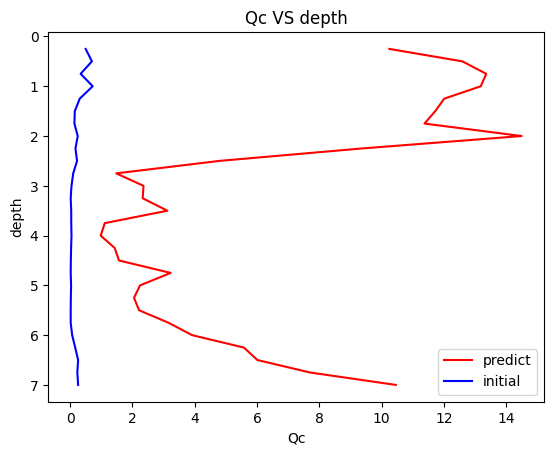

In [ ]:
import matplotlib.pyplot as plt

# Define the x-axis and corresponding y-axis values as lists

ydist=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.25,6.5,6.75,7]


# Plot them on canvas using plt.plot() function
plt.plot(y[0,:], ydist,color='red',label='predict')
plt.plot(x_predictn[0,:], ydist,color='blue',label='initial')
plt.legend()


# Give a name to x-axis and y-axis using plt.xlabel() and plt.ylabel() functions
plt.xlabel("Qc")
plt.ylabel("depth")

# Give a title to your plot using plt.title() function
plt.title("Qc VS depth")
# Get the current axes instance
ax = plt.gca()

# Invert the y-axis
ax.invert_yaxis()

# Finally, to view your plot, we use plt.show() function
plt.show()

In [ ]:
model_transform.save('transformer.h5')

In [ ]:
def mape(y_true, y_pred):
  mape=np.mean(np.abs((Y - y_pred)/Y))*100
  # return mean of percentage errors
  return mape


def mae(y_true, y_pred):
  mae=np.mean(np.abs(Y - y_pred))
  # return mean of percentage errors
  return mae

y=model_transform.predict([x_feature,X_train_CNN,X_train_CNN])
y_pred=sc_y.inverse_transform(y)

mape=mape(Y,y_pred)
mae=mae(Y,y_pred)

print('MAPE=', mape)
print('MAE=', mae)


1/1 [==============================] - 0s 111ms/step
MAPE= 4.565195422831839
MAE= 0.23903581971240817


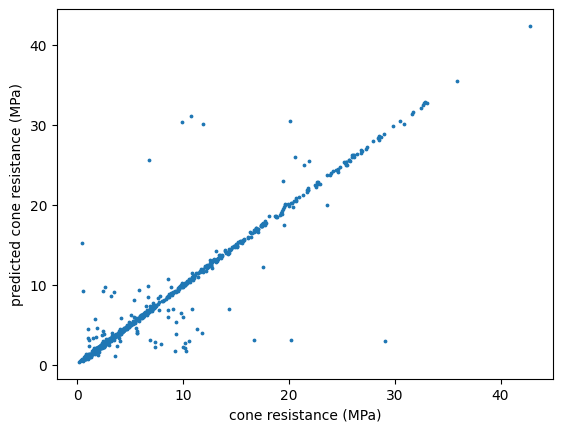

In [ ]:
import matplotlib.pyplot as plt


Y=data[:,34:62]

# Plot the data points as a scatter plot
plt.scatter(y_pred, Y, s=3)

# Add labels and title
plt.xlabel('cone resistance (MPa)')
plt.ylabel('predicted cone resistance (MPa)')


# Show the plot on the screen
plt.show()

In [ ]:
com=np.concatenate((y_pred,Y),axis=0)
np.savetxt('predict.csv', com, delimiter=',')

In [ ]:
Y_sp=y_pred.T
Y_ST=Y.T
for i in range(0,27):
  Y_p=Y_P

In [ ]:
Y_ST.shape

(28, 26)

In [ ]:
#Transformer Autoencoder to predict RIC combind model by Dr. Sompote Youwai 2023
import numpy as np
import pandas as pd

# Import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd



df2 = pd.read_excel('/content/drive/MyDrive/RIC/RIC7aug.xlsx')
data=np.array(df2)
X=data[-2:,1:29]
Y=data[-2:,34:62]
X_feature=data[-2:,29:32]

In [ ]:
Y.shape

(2, 28)

In [ ]:
Y#scale data
X_train=X
Y_train=Y


x_train = sc.transform(X_train)
y_train=sc_y.transform(Y_train)
x_feature=sc_f.transform(X_feature)

In [ ]:
x_feature

array([[-1.37685678, -2.34417712,  0.27530479],
       [-1.37685678, -2.34417712,  0.27530479]])

In [ ]:
X_train_CNN=np.zeros((X.shape[0],X.shape[1],x_feature.shape[1]+1))
X_train_CNN[:,:,0]=x_train
for i in range(0,(X.shape[0])):
  X_train_CNN[i,:,1]=x_feature[i,0]
  X_train_CNN[i,:,2]=x_feature[i,1]
  X_train_CNN[i,:,3]=x_feature[i,2]

In [ ]:
X_train_CNN

array([[[-0.93350493, -1.37685678, -2.34417712,  0.27530479],
        [-0.57271124, -1.37685678, -2.34417712,  0.27530479],
        [ 0.40178498, -1.37685678, -2.34417712,  0.27530479],
        [ 0.86765545, -1.37685678, -2.34417712,  0.27530479],
        [ 0.70489386, -1.37685678, -2.34417712,  0.27530479],
        [ 0.20522221, -1.37685678, -2.34417712,  0.27530479],
        [ 1.02954651, -1.37685678, -2.34417712,  0.27530479],
        [ 2.9617748 , -1.37685678, -2.34417712,  0.27530479],
        [ 1.8313836 , -1.37685678, -2.34417712,  0.27530479],
        [ 1.26810271, -1.37685678, -2.34417712,  0.27530479],
        [ 1.1669807 , -1.37685678, -2.34417712,  0.27530479],
        [ 3.94904658, -1.37685678, -2.34417712,  0.27530479],
        [ 3.77389936, -1.37685678, -2.34417712,  0.27530479],
        [ 0.87160822, -1.37685678, -2.34417712,  0.27530479],
        [-0.36501563, -1.37685678, -2.34417712,  0.27530479],
        [-0.57764094, -1.37685678, -2.34417712,  0.27530479],
        

In [ ]:
y=model_transform.predict([x_feature,X_train_CNN,X_train_CNN])
y_pred=sc_y.inverse_transform(y)

1/1 [==============================] - 0s 32ms/step


In [ ]:
np.savetxt('array2.csv', y_pred, delimiter=',')

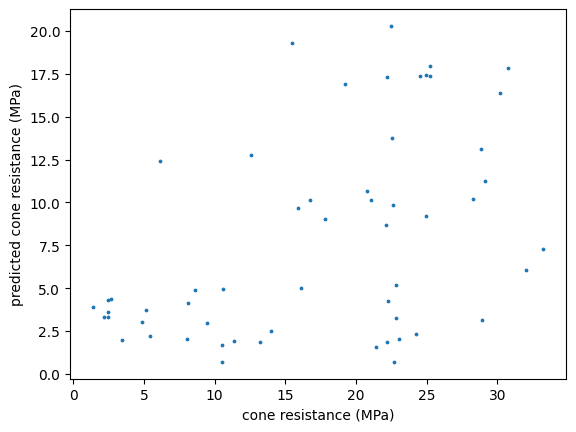

In [ ]:
import matplotlib.pyplot as plt


Y=data[-2:,34:62]

# Plot the data points as a scatter plot
plt.scatter(Y, y_pred, s=3)

# Add labels and title
plt.xlabel('cone resistance (MPa)')
plt.ylabel('predicted cone resistance (MPa)')


# Show the plot on the screen
plt.show()

In [ ]:
y_pred.shape

(2, 28)

In [ ]:
Y.shape

(28, 28)